In [0]:
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score

#Data Import

In [0]:
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [0]:
data1 = pd.read_csv('/content/Drive/My Drive/Colab Notebooks/1000ml/Unit2/Project5/intrusion_detection.csv')
data = pd.read_csv('/content/Drive/My Drive/Colab Notebooks/1000ml/Unit2/Project5/intrusion_detection_notonehot.csv')

In [0]:
print(f'Columns in intrusion_detection_notonehot.csv:  {data.shape[1]}')
print(f'Matching columns in both data sets:  {sum(data.columns.isin(data1.columns))}')

Columns in intrusion_detection_notonehot.csv:  44
Matching columns in both data sets:  40


#Data Cleaning

In [0]:
print(f'Amount of NaN-Values in the entire data set: {sum(data.isnull().sum())}')

Amount of NaN-Values in the entire data set: 0


In [0]:
data.dtypes.value_counts()

float64    38
object      4
int64       2
dtype: int64

#EDA

## Variable selection

* `num_outbounds_cmds`,`land`,`Unnamed: 0`, `id` are dropped
* We will select `outlier@{no,yes}` as the target variable

In [0]:
data.shape

(48113, 44)

In [0]:
data.nunique()

Unnamed: 0                     48113
duration                         238
src_bytes                       2375
dst_bytes                       9169
wrong_fragment                     3
urgent                             3
hot                               18
num_failed_logins                  3
logged_in                          2
num_compromissed                  18
root_shell                         2
su_attempted                       3
num_root                          15
num_file_creations                12
num_shells                         4
num_access_files                   5
num_outbounds_cmds                 1
is_host_login                      2
is_guest_login                     2
count                            335
srv_count                        341
serror_rate                       21
srv_serror_rate                   29
rerror_rate                        6
srv_rerror_rate                   32
same_srv_rate                     66
diff_srv_rate                     83
s

In [0]:
def n_counts_per(dataframe,unique_values = 1):
  for column in dataframe.columns[dataframe.nunique().values == unique_values]:
    print(dataframe[column].value_counts())
    print('----')

In [0]:
n_counts_per(data,1)

0.0    48113
Name: num_outbounds_cmds, dtype: int64
----
0    48113
Name: land, dtype: int64
----


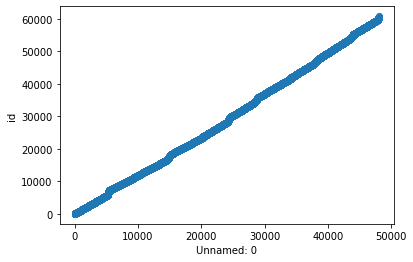

In [0]:
plt.scatter(data['Unnamed: 0'], data['id'])
plt.xlabel('Unnamed: 0')
plt.ylabel('id')
plt.show()

* `land` and `num_outbounds_cmds` only have one unique value. Therefore not very useful for our analysis.
* `Unnamed: 0` and `id` are just unique identifiers per record, that both increase in value. These aren't useful for classication either.

In [0]:
n_counts_per(data,2)

1.0    42475
0.0     5638
Name: logged_in, dtype: int64
----
0.0    48068
1.0       45
Name: root_shell, dtype: int64
----
0.0    48109
1.0        4
Name: is_host_login, dtype: int64
----
0.0    47993
1.0      120
Name: is_guest_login, dtype: int64
----
no     47913
yes      200
Name: outlier@{no,yes}, dtype: int64
----


* We will select `outlier@{no,yes}` as the target variable (and change (yes,no) to (1,0).

In [0]:
#drop columns with 1 unique value or all unique values
data = data.drop(columns= ['num_outbounds_cmds','land','Unnamed: 0', 'id'],axis=1)
#change (yes,no) in target variable to (1,0)
data['outlier@{no,yes}'] = np.where(data['outlier@{no,yes}'] == 'yes', 1, 0)
#slice numerical, categorical and target variables
cat_var = ['protocol_type','service','flag']
target = ['outlier@{no,yes}']
num_var = data.drop(columns= cat_var + target, axis=1).columns

## Exploration

#Model

##Null Model (Simple Logistic Regression)
* Recall Score:
    * Train 0.40540540540540543
    * Validation 0.40384615384615385

In [0]:
#set the variable
x = data[num_var]
x = pd.concat([x,pd.get_dummies(data[cat_var],drop_first=True)],axis=1)
y = data[target]

x_train, x_val, y_train, y_val = train_test_split(x,y,
                                                  test_size = 0.2,
                                                  random_state = 42)

#set the model
#clf stands for classifier
null = LogisticRegression(max_iter=1000)

#fit the model
null.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
print(classification_report(y_train,null.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38342
           1       0.98      0.41      0.57       148

    accuracy                           1.00     38490
   macro avg       0.99      0.70      0.79     38490
weighted avg       1.00      1.00      1.00     38490



In [0]:
print(classification_report(y_val,null.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9571
           1       1.00      0.40      0.58        52

    accuracy                           1.00      9623
   macro avg       1.00      0.70      0.79      9623
weighted avg       1.00      1.00      1.00      9623



In [0]:
print(recall_score(y_train,null.predict(x_train)))
print(recall_score(y_val,null.predict(x_val)))

0.40540540540540543
0.40384615384615385


## Logistic Regression